In [ ]:
#Data folders have frame#.jpg, where # counts up and bar.png which is a screenshot from the first frame

In [1]:
from skimage import filters
from skimage import io
import skimage
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import scipy
from scipy import ndimage
import time

(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 720 1024
(185, 355, 3) 736 1024
(185, 355, 3) 736 1024
(185, 355, 3) 736 1024
(185, 355, 3) 736 1024
(185, 355, 3) 736 1024
(185, 355, 3) 736 1024
(185, 355, 3) 736 1024
(185, 355, 3) 736 1024
(185, 355, 3) 736 1008
(185, 355, 3) 736 1008
(185, 355, 3) 736 1008
(185, 355, 3) 736 992
(185, 355, 3) 736 960
(185, 355, 3) 736 944
(185, 355, 3) 736 928
(185, 355, 3) 736 912
(185, 355, 3) 736 896
(185, 355, 3) 736 864
(185, 355, 3) 736 848
(185, 355, 3) 736 832
(185, 355, 3) 736 816
(185, 355, 3) 736 800
(185, 355, 3) 752 784
(185, 355, 3) 752 768
(185, 355, 3) 752 768
(185, 355, 3) 752 768
(185, 355, 3) 752 768
(185, 355, 3) 752 768
(185, 355, 3) 752 768
(185, 355, 3) 736 768
(185, 355, 3) 736 768
(185, 35

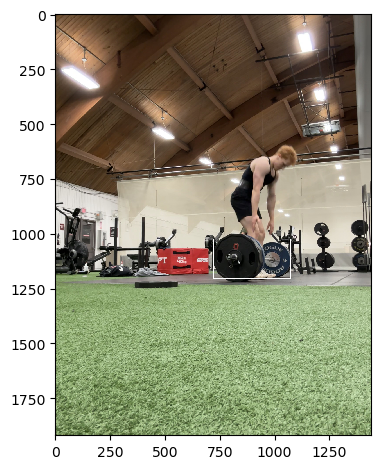

In [41]:
# Sets paramaters and creates tracked video, the current configuration uses a screenshotted template from deadlift1.MOV to track deadlift2.MOV at 10 fps
image_folder = 'deadlift2_10fps'
bar_image = 'bar.png'
num_frames = 67
outfile = 'template__out_of_image.mp4'
#desired output fps
fps = 10
scale = 16
chunk_correction=False

createLabeledVideo(image_folder,bar_image,num_frames,outfile,fps,scale,chunk_correction)

In [35]:
"""
    START HERE, this method calls all the others to produce output.
    
    Given a @folder containing @num_frames frames at @fps and with a template image in the given folder named @template_name (expects .png) 
    produces an @outfile_name (must have .mp4) file with the template in a bounding box.
    @scale is how great a downsampling factor to use 16 means do the searching over an image that is 16 times smaller on each axis
    @chunk_correction when true causes a secondary search to be done on the full size image after the downsampled search
"""
def createLabeledVideo(folder,template_name,num_frames,outfile_name,fps,scale=16,chunk_correction=False):
    frames = np.array([io.imread(f'./{folder}/frame{i}.jpg') for i in range(0,num_frames)])
    bar_template = np.array(io.imread(f'./{folder}/{template_name}'))
    bar_template = bar_template[:,:,0:3]
    
    #copy of frames with box drawn on
    out_frames = [np.array(frames[i]) for i in range(num_frames)]
    
    for i in range(len(frames)):
        x,y = matchFrame(bar_template,frames[i],scale=scale,chunk_correction=chunk_correction)

        #Draws a rectangle around the template
        out_frames[i][y:y+bar_template.shape[0],x:x+3] = (255,255,255)
        out_frames[i][y:y+bar_template.shape[0],x+bar_template.shape[1]-3:x+bar_template.shape[1]] = (255,255,255)
        out_frames[i][y:y+3,x:x+bar_template.shape[1]] = (255,255,255)
        out_frames[i][y+bar_template.shape[0]-3:y+bar_template.shape[0],x:x+bar_template.shape[1]] = (255,255,255)

        #Redraws the template from the most recent frame, assumes that the bar will look most similiar in the previous and next frames.
        #On account of the downsampling if chunk_correction isn't used this redrawing can over time lose track of the original template as the redrawing drifts
        #template = frames[i][y:y+bar_template.shape[0],x:x+bar_template.shape[1]]


    createVideoFromFrames(out_frames,outfile_name,fps=fps)

In [4]:
#1920 x 1440 images are simply to large so we blur and downsample both the image and the template to find the correct area and then do a search over that specific area
#radius of filter matches how many times smaller the image is reduced
"""
    blurs the given @im using a guassian filter with @sigma and downscales by @scale(ie 32 means 32 times smaller on both width and height)
"""
def blur_and_downsample(im,scale=16,sigma=16):
    
    blurred_im = filters.gaussian(im, sigma=sigma,truncate=sigma/scale,channel_axis=-1)
    downscaled_im = blurred_im[::scale,::scale,::]
    return downscaled_im
    

In [5]:
"""
    Returns the x,y position in the search image with the highest NCC score, this method is lifted directly from HW9
    @imTemp is the template smaller in size than the search image
    @imSearch is the search image to find the closest match to the template in
"""
def findTemplate(imTemp,imSearch):
    
        
    tempHeight = imTemp.shape[0]
    tempWidth = imTemp.shape[1]

    tBar = imTemp.mean(axis=(0,1))
    tSigma = imTemp.std(axis=(0,1))

    # NCC values and (x,y) coordinates
    NCC = (0,0,0)

    #Grab all valid regions in image
    for x in range(0,imSearch.shape[1] - imTemp.shape[1]):
        for y in range(0,imSearch.shape[0] - imTemp.shape[0]):
            #Iterate this region
            region = imSearch[y:y+tempHeight,x:x+tempWidth]
            sBar = region.mean(axis=(0,1))
            sSigma = region.std(axis=(0,1))

            #NCC formula, I lump all three color channels together so ends up between 0 and 3 values close to 3 being a near match
            NCCScore = (1 / ((tempHeight * tempWidth) - 1)) * np.sum(((region - sBar) * (imTemp - tBar)) / ( tSigma * sSigma))
            if NCC[0] < NCCScore:
                NCC = NCCScore, x,y
    #Returns x,y position in image of the best NCC value
    return NCC[1], NCC[2]

In [6]:

"""
    Handles finding the x,y coords of the top left corner of a @template in @frame
    @scale controls how much downsizing is done, 16 means the template matching is done on an image with 1/16 the scale
    @display_images will display the various stages of images when True
    @chunk_correction when true a second phase is added that rescans the original image around where the downsized template was found. 
    Without this the template is only found within the proximity of the downsizing which depends on scale. With this its pixel accurate but, takes significantly longer

"""
def matchFrame(template,frame,scale=16,display_images=False,chunk_correction=False):
    

    if display_images:
        fig,ax = plt.subplots(1,3 if chunk_correction else 2,figsize=(12,6))
    
    temp_width, temp_height = template.shape[1],template.shape[0]
    down_frame = blur_and_downsample(frame,scale=scale)
    down_template = blur_and_downsample(template,scale=scale)
    x,y = findTemplate(down_template,down_frame)
    if display_images:
        rect = patches.Rectangle((x,y), temp_width / scale,temp_height /scale, linewidth=2, edgecolor='b', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].imshow(down_frame)
        ax[0].set_title("Downscaled Location")
        

    #Scales back up to the original image size
    x,y = x*scale,y*scale
    
    if display_images:        
        rect = patches.Rectangle((x,y), temp_width, temp_height, linewidth=2, edgecolor='b', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].set_title(f"Chunk Location ({x},{y})")
        ax[1].imshow(frame)
        
    #Rescans the chunk in the original image to find the template to the pixel, if the chunk is quiet large this is an important catch but is time consuming
    if chunk_correction:
        #The chunk starts at x-scale,y-scale so these values have that as their 0,0
        chunk_correction_x,chunk_correction_y = findTemplate(template,frame[y-scale:y+scale+temp_height,x-scale:x+scale+temp_width])
        print(chunk_correction_x,chunk_correction_y)
        x,y = x+chunk_correction_x-scale,y+chunk_correction_y-scale
        if display_images:
            rect = patches.Rectangle((x,y), temp_width, temp_height, linewidth=2, edgecolor='b', facecolor='none')
            ax[2].add_patch(rect)
            ax[2].set_title(f"Correct Location ({x},{y})")
            ax[2].imshow(frame)
            
    return x,y
    

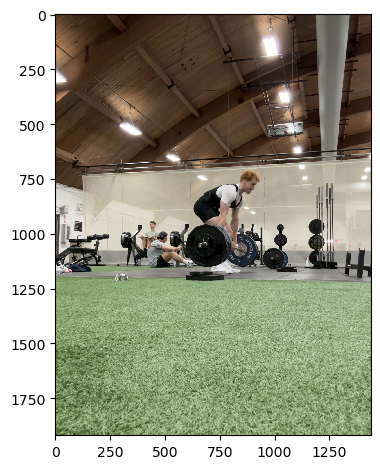

In [32]:
def createVideoFromFrames(frames,out_file,fps=30):
    io.imshow(frames[5])
    out = cv2.VideoWriter(out_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frames[0].shape[1], frames[0].shape[0]))
    for i in range(len(frames)):
        out.write(cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR))
    out.release()

# frames = np.array([io.imread(f'./deadlift1_2fps/frame{i}.jpg') for i in range(0,14)])
# createVideoFromFrames(frames,'template.mp4',14)

Time for scale=8, chunk_correction=True is 5.5407538414001465
Time for scale=8, chunk_correction=False is 3.695582866668701
Time for scale=16, chunk_correction=True is 6.930499076843262
Time for scale=16, chunk_correction=False is 0.6838037967681885
Time for scale=32, chunk_correction=True is 25.731998920440674
Time for scale=32, chunk_correction=False is 0.31427526473999023
Time for scale=64, chunk_correction=True is 103.83225393295288
Time for scale=64, chunk_correction=False is 0.21840691566467285


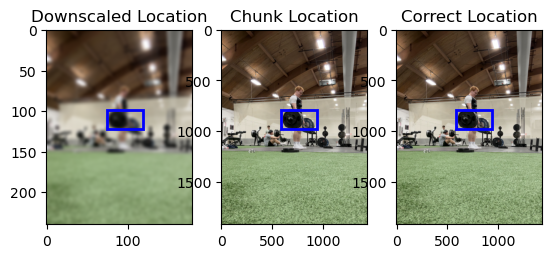

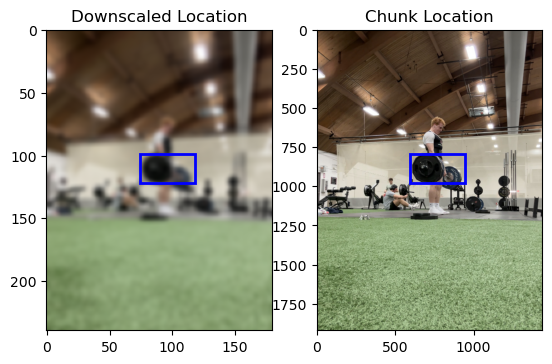

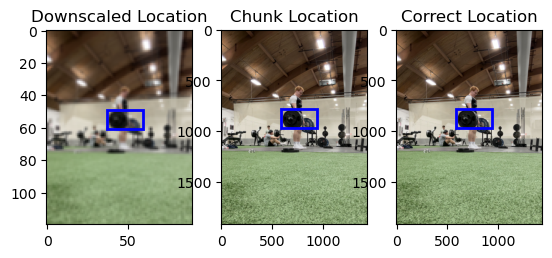

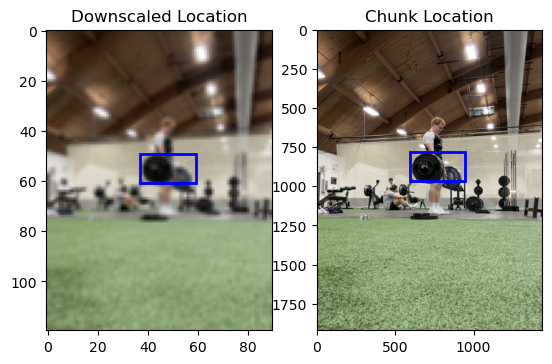

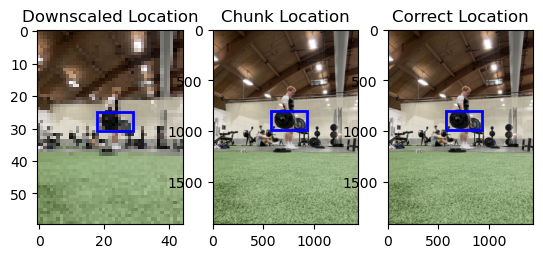

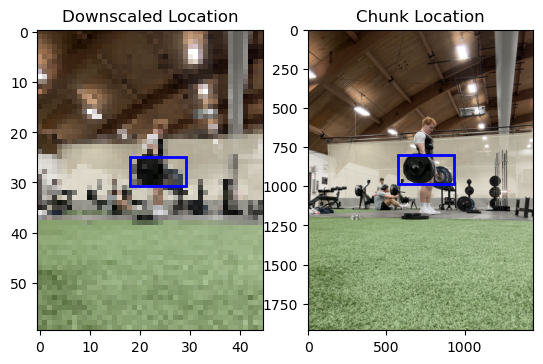

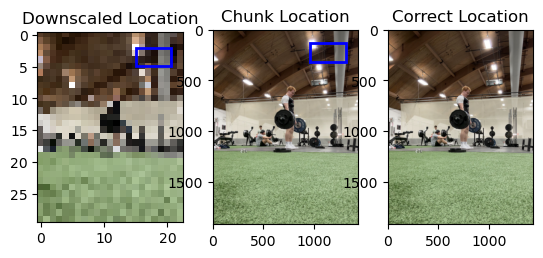

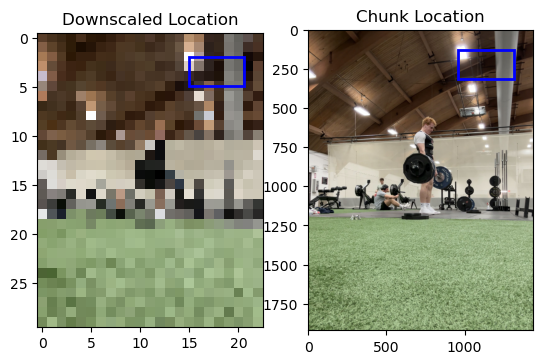

In [10]:
# Runs frame matching for various scales and with chunk_correction on and off. Was used to get images for the project slidewshow.
for scale in [8,16,32,64]:
    for chunk_correction in [True,False]:
        t0 = time.time()
        matchFrame(bar_template,frames[40],scale=scale,display_images=True,chunk_correction=chunk_correction)
        t1 = time.time()
        print(f"Time for scale={scale}, chunk_correction={chunk_correction} is {t1-t0}")